# Examples of unrealistic behaviours in iML1515
This notebook collates a set of unrealistic metabolic behaviours that can occur when applying simple stoichiometric analyses, such as FBA, on large metabolic networks with many degrees of freedom. As an example, the genome-scale parent of iCH360, iML1515, is used. We stress that these behaviour are not the result of errors in the large model. Rather, they are a result of the simple constraints imposed by methods such as FBA, which cannot account for important factors such as thermodynamics, enzyme demand, regulatory effects, and others.

In [8]:
import cobra
from cobra.flux_analysis import pfba
import sys
sys.path.append('../../utils')
import model_assembly_utils
import visualisation_utils


# importing package 
import matplotlib.pyplot as plt 
import numpy as np 
  


In [9]:

iml1515=cobra.io.read_sbml_model('../../Manuscript_Figures/data/metabolic_models/iML1515/iML1515.xml')
ich360=cobra.io.read_sbml_model('../../Model/iCH360/Escherichia_coli_iCH360.xml')

## Fatty acids production
In the (p)FBA solution computed on iML1515 using glucose as a carbon source and growth as an objective, the canonical fatty acid production pathway in *E. Coli* is completely unused.

In [10]:
fatty_acids_reactions=model_assembly_utils.get_reactions_from_excher_map('../../Visualisation/pathway_maps/fatty_acids_biosynthesis.json')
sol=pfba(iml1515)
sol.fluxes.loc[fatty_acids_reactions]

ACCOAC     0.068257
3HAD40     0.000000
3OAR40     0.000000
MCOATA     0.068255
3OAS60     0.000000
3OAR60     0.000000
3HAD60     0.000000
3OAS80     0.000000
3OAR80     0.000000
3HAD80     0.000000
EAR40x     0.000000
EAR60x     0.000000
KAS15      0.000000
EAR80x     0.000000
3OAS100    0.000000
3OAR100    0.000000
3HAD100    0.000000
EAR100x    0.000000
3OAS120    0.000000
3OAR120    0.000000
3HAD120    0.000000
EAR120x    0.000000
3OAS160    0.000000
3OAS140    0.068251
3OAR140    0.068251
3HAD140    0.000000
EAR140x    0.000000
3OAR160    0.000000
3HAD160    0.000000
EAR160x    0.000000
EAR60y     0.000000
EAR80y     0.000000
KAS14      0.000000
ACOATA     0.000000
EAR100y    0.000000
3OAS180    0.000000
3OAR180    0.000000
3HAD180    0.000000
EAR180x    0.000000
EAR180y    0.000000
EAR160y    0.000000
EAR140y    0.000000
EAR120y    0.000000
T2DECAI    0.000000
3OAS121    0.000000
3OAR121    0.000000
3HAD121    0.000000
EAR121x    0.000000
3OAS141    0.000000
3OAR141    0.000000


Instead, the genome-scale model is running beta oxidation in reverse

In [11]:
visualisation_utils.flux2json(sol.fluxes, 'out/iML1515_glucose_aerobic_pfba.json' )
# We visualised the exported solution on the iJO1366 fatty acids beta oxidation map available on Escher

![alt text](images/iml1515_fatty_acids_production.png)

# Pyruvate auxotrophs
From an experimental point of view, few knockouts in central metabolism are typical sufficient to generate a pyruvate auxotroph strain. For example, in DOI 10.1038/s41467-018-04417-z , a triple KO maeA (b1479, ME1) maeB (b2463, ME2) pck (b3403, PPCK) was shown to result in pyruvate auxotrophy using acetate as the sole carbon source.

Indeed, we see that this i the case in iCH360:

In [12]:
iCH360_growth_rates={}
with ich360 as m:
    m.reactions.EX_glc__D_e.lower_bound=0
    m.reactions.EX_ac_e.lower_bound=-10.0
    for KO in ['ME1','ME2','PPCK']:
        m.reactions.get_by_id(KO).knock_out()

    sol_without_pyruvate=m.optimize()
    iCH360_growth_rates['without_pyruvate']=sol_without_pyruvate.fluxes['Biomass']

    m.reactions.EX_pyr_e.lower_bound=-10.0
    sol_with_pyruvate=m.optimize()
    iCH360_growth_rates['with_pyruvate']=sol_with_pyruvate.fluxes['Biomass']
print(f'iCH360 ' +r'DELTA'+'(' + ','.join(['ME1','ME2','PPCK']) +')')
print(iCH360_growth_rates)
    

iCH360 DELTA(ME1,ME2,PPCK)
{'without_pyruvate': 0.0, 'with_pyruvate': 0.5439169324613089}


However, iML1515 easily bypasses these KOs:

In [13]:
iml1515_growth_rates={}
with iml1515 as m:
    m.reactions.EX_glc__D_e.lower_bound=0
    m.reactions.EX_ac_e.lower_bound=-10.0
    for KO in ['ME1','ME2','PPCK']:
        m.reactions.get_by_id(KO).knock_out()


    sol_without_pyruvate=m.optimize()
    iml1515_growth_rates['without_pyruvate']=sol_without_pyruvate.fluxes['BIOMASS_Ec_iML1515_core_75p37M']

    m.reactions.EX_pyr_e.lower_bound=-10.0
    sol_with_pyruvate=m.optimize()
    iml1515_growth_rates['with_pyruvate']=sol_with_pyruvate.fluxes['BIOMASS_Ec_iML1515_core_75p37M']
print(f'iML1515 ' +r'DELTA'+'(' + ','.join(['ME1','ME2','PPCK']) +')')
print(iml1515_growth_rates)
    

iML1515 DELTA(ME1,ME2,PPCK)
{'without_pyruvate': 0.21009920466530313, 'with_pyruvate': 0.5499433531174456}


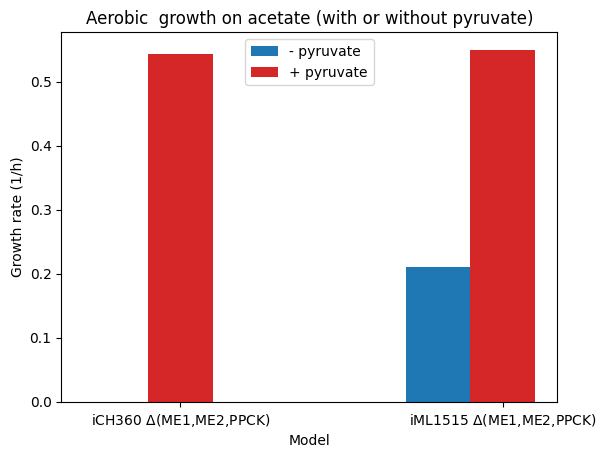

In [14]:

# create data 
x = np.array([0,1])
y1 = [iCH360_growth_rates['without_pyruvate'], iml1515_growth_rates['without_pyruvate']] 
y2 = [iCH360_growth_rates['with_pyruvate'], iml1515_growth_rates['with_pyruvate']] 
width = 0.2
  
# plot data in grouped manner of bar type 
plt.bar(x-0.2, y1, width, color='tab:blue') 
plt.bar(x, y2, width, color='tab:red') 
plt.xticks(x, [f'iCH360 ' +r'$\Delta$'+'(' + ','.join(['ME1','ME2','PPCK']) +')',
                f'iML1515 ' +r'$\Delta$'+'(' + ','.join(['ME1','ME2','PPCK']) +')']) 
plt.xlabel("Model") 
plt.ylabel("Growth rate (1/h)") 
plt.legend(["- pyruvate", "+ pyruvate"],loc='upper center') 
plt.title('Aerobic  growth on acetate (with or without pyruvate)')
plt.show() 

## Uptake of external CO2 for additional pyruvate production under anaerobic conditions
Under unaerobic conditions, iML1515 can uptake external CO2 and use it as an electron sink for glycolytic electrons, reducing acetyl-CoA produced by PFL back into pyruvate. this behaviour, which allows the model to channel additional carbon towards pyruvate, is thermodynamically unrealistic under ambient CO2 conditions.

In [15]:
with iml1515 as m:
    m.objective='EX_pyr_e'
    m.reactions.EX_o2_e.lower_bound=0
    sol=m.optimize()
    visualisation_utils.flux2json(sol.fluxes,'out/anaerobic_pyruvate_production.json')

![alt text](images/co2_as_electron_sink.png)

# Acetyl-CoA auxotroph strain

In DOI 10.1038/s41467-018-04417-z, an acetyl-CoA auxotroph E. coli strain is created by KO of 4 genes:
- aceEF (b0114, b0115), disrupting PDH reaction
- pflB b0903, disrupting PFL
- poxB (b0871), disrupting the pyruvate oxidase POX 
 The strain cannot grow on glucose as a sole carbon source, but can grow if medium is supplemented with acetate


iML1515 easily bypasses these KO and grow solely on glucose:

In [35]:
with iml1515 as m:
    m.reactions.EX_glc__D_e.lower_bound=-10
    for KO in ['PFL','PDH']:
        m.reactions.get_by_id(KO).knock_out()


    sol=m.optimize()
    acetyl_coa_production=m.metabolites.accoa_c.summary()
sol

,fluxes,reduced_costs
CYTDK2,0.000000,2.385245e-18
XPPT,0.000000,0.000000e+00
HXPRT,0.000000,-7.925403e-03
NDPK5,-6.458192,-0.000000e+00
SHK3Dr,0.320009,1.149254e-17
...,...,...
MPTS,0.000000,-2.775558e-17
MOCOS,0.000000,0.000000e+00
BMOGDS2,0.000000,0.000000e+00
FESD2s,0.000000,0.000000e+00


iCH360 cannot grow on glucose after after these knockouts:

In [40]:
with ich360 as m:
    m.reactions.EX_glc__D_e.lower_bound=-10
    for KO in ['PFL','PDH']:
        if KO in KO:
            m.reactions.get_by_id(KO).knock_out()


    sol=m.optimize()
    sol
sol

,fluxes,reduced_costs
NDPK5,0.0,0.0
SHK3Dr,0.0,0.0
NDPK6,0.0,0.0
NDPK8,0.0,0.0
DHORTS,0.0,0.0
...,...,...
VPAMTr,0.0,0.0
PIt2rpp,0.0,0.0
PItpp,0.0,0.0
SUCCt1pp,0.0,0.0


but can grow upon supplementation with acetate, as shown experimentally.

In [42]:
with ich360 as m:
    m.reactions.EX_glc__D_e.lower_bound=-10
    m.reactions.EX_ac_e.lower_bound=-10
    for KO in ['PFL','PDH']:
        if KO in KO:
            m.reactions.get_by_id(KO).knock_out()


    sol=m.optimize()
    sol
sol

,fluxes,reduced_costs
NDPK5,0.028111,2.775558e-17
SHK3Dr,0.395387,0.000000e+00
NDPK6,0.027225,0.000000e+00
NDPK8,0.027225,0.000000e+00
DHORTS,-0.344186,-0.000000e+00
...,...,...
VPAMTr,0.000000,-1.387779e-17
PIt2rpp,1.002539,0.000000e+00
PItpp,0.000000,-2.035054e-03
SUCCt1pp,0.000000,0.000000e+00
